In [1]:
import os
import time
from itertools import islice
from datetime import timedelta

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from parcllabs import ParclLabsClient
from parcllabs.beta.charting.utils import create_labs_logo_dict
from parcllabs.beta.charting.styling import default_style_config as style_config


client = ParclLabsClient(
    api_key=os.environ.get('PARCL_LABS_API_KEY', "<your Parcl Labs API key if not set as environment variable>"), 
    limit=12 # set default limit
)

In [2]:
# in this case, lets look at Tampa market at the metro level
tampa_market = client.search.markets.retrieve(
    query='Tampa',
    sort_by='TOTAL_POPULATION',
    location_type='CITY',
    sort_order='DESC',
    limit=1
)

tampa_market.head()

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
0,5352995,USA,1271000,12,Tampa City,FL,SOUTH_ATLANTIC,CITY,388768,66802,0,1,0,0


In [14]:
nl.head()

,date,rolling_7_day,rolling_30_day,rolling_60_day,rolling_90_day,parcl_id,property_type
0,2024-07-08,164,959,2039,3186,5352995,ALL_PROPERTIES
1,2024-07-01,244,989,2119,3249,5352995,ALL_PROPERTIES
2,2024-06-24,200,930,2107,3192,5352995,ALL_PROPERTIES
3,2024-06-17,250,953,2156,3207,5352995,ALL_PROPERTIES
4,2024-06-10,201,926,2112,3134,5352995,ALL_PROPERTIES


|████████████████████████████████████████| 1/1 [100%] in 0.1s (8.46/s) 


<Axes: title={'center': 'New Listings in Tampa Market'}, xlabel='date'>

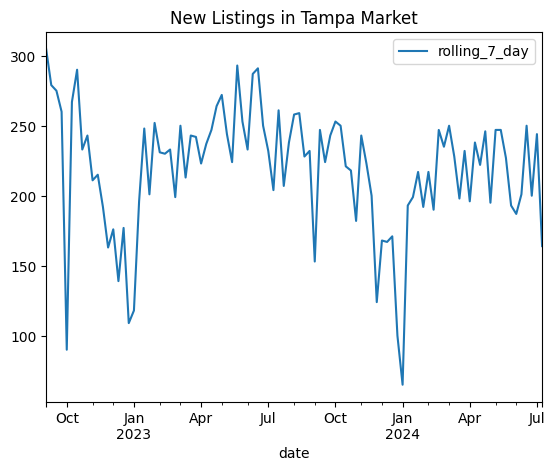

In [18]:
nl = client.for_sale_market_metrics.new_listings_rolling_counts.retrieve(
    parcl_ids=tampa_market['parcl_id'].values,
    start_date='2022-09-01',
    limit=1000,
    property_type='ALL_PROPERTIES'
)

nl.plot(x='date', y='rolling_7_day', title='New Listings in Tampa Market')

In [9]:
nll = nl.melt(id_vars=['date', 'parcl_id', 'property_type'], var_name='parcl_id', value_name='new_listings')
nll = nll.rename(columns={'parcl_id': 'Rolling Window'})
nll.head(1)

,date,Rolling Window,property_type,Rolling Window,new_listings
0,2024-07-08,rolling_7_day,ALL_PROPERTIES,rolling_7_day,164


In [13]:
max_date_for_chart = nll['date'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')

# Create the line chart using Plotly Express
fig = px.line(
    nll,
    x='date',
    y='new_listings',
    color='Rolling Window',
    line_group='Rolling Window',
    labels={'Rolling Window': '% Change since Original List'},
    title=f'% Change since Original List by Unit Type'
)

# Find the latest date in the dataset
latest_date = max(nll['date'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = nll[
        (nll['Rolling Window'] == trace.name) &
        (nll['date'] == latest_date)
    ]['new_listings'].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='% Change in Price since Original List',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        # tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


ValueError: 2